<a href="https://colab.research.google.com/github/Chloe1111322/GW/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-604b503576d8>:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=10, random_state=42) if len(x) >= 10 else x)


                            OLS Regression Results                            
Dep. Variable:       location_numeric   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.105
Method:                 Least Squares   F-statistic:                   0.09759
Date:                Sun, 12 Jan 2025   Prob (F-statistic):              0.908
Time:                        15:33:48   Log-Likelihood:                -14.402
No. Observations:                  20   AIC:                             34.80
Df Residuals:                      17   BIC:                             37.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5469      0.307      1.779   

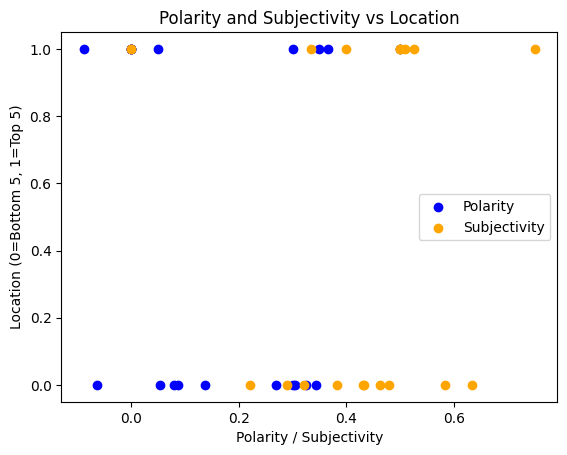

In [2]:
import os
import re
import pandas as pd
from textblob import TextBlob
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Function to extract and clean text from txt files
def extract_and_clean_text_from_txt(file_path, party, location):
   if not os.path.exists(file_path):
       raise FileNotFoundError(f"The file at {file_path} does not exist. Please check the path.")


   data = []
   current_speaker = None


   with open(file_path, 'r', encoding='utf-8') as file:
       for line in file:
           line = line.strip()


           # Check for speaker/constituency pattern (e.g., "Seema Kennedy (7 May 2015~):")
           match = re.match(r"^(.*?):\s*$", line)
           if match:
               current_speaker = match.group(1)
           elif current_speaker and line:
               # Add cleaned text to the list with speaker/context
               data.append({"speaker": current_speaker, "text": line, "party": party, "location": location})


   return pd.DataFrame(data)


# Define file paths and check their existence
top5_file = 'Top5.txt'
bottom5_file = 'Bottom5.txt'


# Provide a fallback or prompt user to ensure files exist
if not os.path.exists(top5_file):
   raise FileNotFoundError(f"The file {top5_file} is missing. Ensure the file is uploaded to the correct directory.")
if not os.path.exists(bottom5_file):
   raise FileNotFoundError(f"The file {bottom5_file} is missing. Ensure the file is uploaded to the correct directory.")


# Load and clean text data from txt files
top5_data = extract_and_clean_text_from_txt(top5_file, 'Conservative', 'Top 5')
bottom5_data = extract_and_clean_text_from_txt(bottom5_file, 'Labour', 'Bottom 5')


# Combine datasets
data = pd.concat([top5_data, bottom5_data], ignore_index=True)


# Function to analyze polarity and subjectivity
def analyze_text(text):
   blob = TextBlob(text)
   return blob.polarity, blob.subjectivity


# Apply text analysis
data[['polarity', 'subjectivity']] = data['text'].apply(lambda x: pd.Series(analyze_text(x)))


# Group data by location and sample 10 texts per group
sampled_data = (
   data.groupby(['location'], group_keys=False)
   .apply(lambda x: x.sample(n=10, random_state=42) if len(x) >= 10 else x)
)


# Prepare data for regression
# Map location names to numeric values (e.g., 'Bottom 5' -> 0, 'Top 5' -> 1)
location_mapping = {'Bottom 5': 0, 'Top 5': 1}
sampled_data['location_numeric'] = sampled_data['location'].map(location_mapping)


# Perform regression
X = sampled_data[['polarity', 'subjectivity']]
y = sampled_data['location_numeric']


# Add constant for statsmodels
X = sm.add_constant(X)


# Fit the regression model
model = sm.OLS(y, X).fit()


# Print the regression summary
print(model.summary())


# Visualize the results
plt.scatter(sampled_data['polarity'], y, color='blue', label='Polarity')
plt.scatter(sampled_data['subjectivity'], y, color='orange', label='Subjectivity')
plt.xlabel('Polarity / Subjectivity')
plt.ylabel('Location (0=Bottom 5, 1=Top 5)')
plt.legend()
plt.title('Polarity and Subjectivity vs Location')
plt.savefig('polarity_subjectivity_vs_location.png')



